# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
train_data = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv")
test_data= pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv")

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


# 데이터 전처리

### motor_vibe 이상치 대체: KNNImputer

In [21]:
# 중복데이터 144개: 시계열 데이터이므로 큰 상관 없을 것으로 판단
# train_data = train_data.drop_duplicates()
# train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [61]:
# 20HP 에서 motor_vibe값이 이상치로 판단되는 행 보간: 16개
train_data.loc[train_data['motor_vibe'] > 15.0, 'motor_vibe'] = None

In [65]:
train_data.iloc[range(581, 597), :]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
581,0.94,38.69,0.7,13.41,1495.0,56.61,NaN,1
582,1.21,44.14,0.7,17.33,1931.0,61.46,NaN,1
583,1.36,47.04,0.7,19.41,2163.0,64.03,NaN,1
584,1.05,40.83,0.7,14.95,1666.0,58.51,NaN,1
585,1.91,58.00,0.7,27.28,3040.0,73.78,NaN,1
586,1.16,43.15,0.7,16.62,1852.0,60.58,NaN,1
587,1.31,46.09,0.7,18.73,2087.0,63.19,NaN,1
588,0.98,39.46,0.7,13.97,1557.0,57.30,NaN,1
589,1.57,51.31,0.7,22.48,2505.0,67.83,NaN,1
590,1.71,53.96,0.7,24.38,2717.0,70.19,NaN,1


In [66]:
from sklearn.impute import KNNImputer

In [67]:
imputer = KNNImputer(n_neighbors=5)
data_filled = imputer.fit_transform(train_data)
train_data = pd.DataFrame(data_filled, columns=train_data.columns)

In [68]:
train_data.iloc[range(581, 597), :]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
581,0.94,38.69,0.7,13.41,1495.0,56.61,2.750,1.0
582,1.21,44.14,0.7,17.33,1931.0,61.46,3.030,1.0
583,1.36,47.04,0.7,19.41,2163.0,64.03,3.060,1.0
584,1.05,40.83,0.7,14.95,1666.0,58.51,2.806,1.0
585,1.91,58.00,0.7,27.28,3040.0,73.78,3.610,1.0
586,1.16,43.15,0.7,16.62,1852.0,60.58,2.950,1.0
587,1.31,46.09,0.7,18.73,2087.0,63.19,3.080,1.0
588,0.98,39.46,0.7,13.97,1557.0,57.30,2.786,1.0
589,1.57,51.31,0.7,22.48,2505.0,67.83,3.290,1.0
590,1.71,53.96,0.7,24.38,2717.0,70.19,3.390,1.0


### 데이터 증강

In [78]:
temp_0 = train_data.loc[train_data['type'] == 0, :]
temp_1 = train_data.loc[train_data['type'] == 1, :]
temp_2 = train_data.loc[train_data['type'] == 2, :]
temp_3 = train_data.loc[train_data['type'] == 3, :]
temp_4 = train_data.loc[train_data['type'] == 4, :]
temp_5 = train_data.loc[train_data['type'] == 5, :]
temp_6 = train_data.loc[train_data['type'] == 6, :]
temp_7 = train_data.loc[train_data['type'] == 7, :]

In [80]:
temp_0.to_csv("new_train_data_0.csv")
temp_1.to_csv("new_train_data_1.csv")
temp_2.to_csv("new_train_data_2.csv")
temp_3.to_csv("new_train_data_3.csv")
temp_4.to_csv("new_train_data_4.csv")
temp_5.to_csv("new_train_data_5.csv")
temp_6.to_csv("new_train_data_6.csv")
temp_7.to_csv("new_train_data_7.csv")

In [81]:
test_0 = test_data.loc[test_data['type'] == 0, :]
test_1 = test_data.loc[test_data['type'] == 1, :]
test_2 = test_data.loc[test_data['type'] == 2, :]
test_3 = test_data.loc[test_data['type'] == 3, :]
test_4 = test_data.loc[test_data['type'] == 4, :]
test_5 = test_data.loc[test_data['type'] == 5, :]
test_6 = test_data.loc[test_data['type'] == 6, :]
test_7 = test_data.loc[test_data['type'] == 7, :]

In [82]:
test_0.to_csv("new_test_data_0.csv")
test_1.to_csv("new_test_data_1.csv")
test_2.to_csv("new_test_data_2.csv")
test_3.to_csv("new_test_data_3.csv")
test_4.to_csv("new_test_data_4.csv")
test_5.to_csv("new_test_data_5.csv")
test_6.to_csv("new_test_data_6.csv")
test_7.to_csv("new_test_data_7.csv")

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.manifold import TSNE

# def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=10):
#     # Feature 선택
#     X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]

#     # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
#     kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)

#     # 클러스터링 결과 중심점을 centroids에 저장합니다.
#     centroids = kmeans.cluster_centers_

#     # 각 클러스터의 개수를 저장합니다.
#     cluster_sizes = np.bincount(kmeans.labels_)

#     # 각 클러스터에서 t-SNE를 이용하여 2차원으로 축소한 데이터를 생성합니다.
#     tsne = TSNE(n_components=2, perplexity=30, random_state=42)
#     X_tsne = tsne.fit_transform(X)
#     new_data_tsne = []
#     for i, centroid in enumerate(centroids):
#         # 해당 클러스터에 속하는 데이터를 추출합니다.
#         cluster_data = X_tsne[kmeans.labels_ == i]
#         # 해당 클러스터의 중심점을 중심으로 한 가우시안 분포를 생성합니다.
#         mean, std = cluster_data.mean(axis=0), cluster_data.std(axis=0)
#         # 해당 클러스터에서 새로운 데이터를 생성합니다.
#         new_cluster_data = np.random.normal(loc=mean, scale=std, size=(int(num_new_data * cluster_sizes[i] / len(X)), 2))
#         new_data_tsne.append(new_cluster_data)

#     # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
#     new_data = np.concatenate(new_data_tsne, axis=0)
#     # new_data = tsne.inverse_transform(new_data)
#     new_data = pd.DataFrame(new_data, columns=X.columns)

#     # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
#     final_data = pd.concat([train_data, new_data], ignore_index=True)

#     return final_data

from sklearn.cluster import KMeans

def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=7):
    # Feature 선택
    X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]

    # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
    kmeans = KMeans(n_clusters=n_clusters, n_init=10000, random_state=42).fit(X)

    # 클러스터링 결과 중심점을 centroids에 저장합니다.
    centroids = kmeans.cluster_centers_

    # 각 클러스터의 개수를 저장합니다.
    cluster_sizes = np.bincount(kmeans.labels_)

    # 새로운 데이터를 저장할 빈 리스트를 생성합니다.
    new_data = []

    # 각 클러스터의 중심점을 이용하여 새로운 데이터를 생성합니다.
    for i, centroid in enumerate(centroids):
        for j in range(int(num_new_data * cluster_sizes[i] / len(X))):
            # 중심점 주변에 임의의 값으로 노이즈를 추가합니다.
            new_point = centroid + np.random.normal(scale=0.1, size=len(centroid))
            new_data.append(new_point)

    # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
    new_data = pd.DataFrame(new_data, columns=X.columns)

    # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
    final_data = pd.concat([train_data, new_data], ignore_index=True)

    return final_data

In [ ]:
new_temp_0 = cluster_based_augmentation(temp_0, num_new_data=1700, n_clusters=7)
new_temp_1 = cluster_based_augmentation(temp_1)
new_temp_2 = cluster_based_augmentation(temp_2)
new_temp_3 = cluster_based_augmentation(temp_3)
new_temp_4 = cluster_based_augmentation(temp_4, num_new_data=1700, n_clusters=7)
new_temp_5 = cluster_based_augmentation(temp_5, num_new_data=1700, n_clusters=7)
new_temp_6 = cluster_based_augmentation(temp_6, num_new_data=1700, n_clusters=7)
new_temp_7 = cluster_based_augmentation(temp_7, num_new_data=1700, n_clusters=7)
new_temp_0['type'] = 0
new_temp_1['type'] = 1
new_temp_2['type'] = 2
new_temp_3['type'] = 3
new_temp_4['type'] = 4
new_temp_5['type'] = 5
new_temp_6['type'] = 6
new_temp_7['type'] = 7

final_data = pd.concat([new_temp_0, new_temp_1, new_temp_2, new_temp_3, new_temp_4, new_temp_5, new_temp_6, new_temp_7], ignore_index=True)
final_data['out_pressure'] = 0.7

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

final_data['hp'] = final_data['type'].map(mapping_dict)
test_data['hp'] = test_data['type'].map(mapping_dict)

### type -> hp(Horse Power)
    * type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

train_data['hp'] = train_data['type'].map(mapping_dict)
test_data['hp'] = test_data['type'].map(mapping_dict)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
 8   hp             2463 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 173.3 KB


### 새로운 Feature 추가하기

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
final_data['air_inflow_per_motor_current'] = final_data['air_inflow'] / final_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
final_data['Compressor_Efficiency1'] = final_data['out_pressure'] * final_data['air_inflow'] / final_data['motor_current'] / 3.5168 / final_data['hp']
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168 / test_data['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
final_data['Motor_Efficiency'] = (final_data['motor_current'] * final_data['motor_rpm'] * final_data['hp']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

# 압축기의 효율2
final_data['Compressor_Efficiency2'] = (final_data['out_pressure'] * final_data['air_inflow'] * (final_data['air_end_temp'] - 25)) / (final_data['motor_current'] * final_data['motor_vibe'] * final_data['hp'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

# 압축기의 배출량
final_data['Discharge_Volume'] = (final_data['air_inflow'] / 60) * ((final_data['air_end_temp'] + 273) / 273) * (final_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
final_data['air_density'] = final_data['out_pressure'] / (287 * (final_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

In [ ]:
# 모터 전류 당 공기 유량은 압축기의 효율성
train_data['air_inflow_per_motor_current'] = train_data['air_inflow'] / train_data['motor_current']	
test_data['air_inflow_per_motor_current'] = test_data['air_inflow'] / test_data['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
train_data['Compressor_Efficiency1'] = train_data['out_pressure'] * train_data['air_inflow'] / train_data['motor_current'] / 3.5168 / train_data['hp']
test_data['Compressor_Efficiency1'] = test_data['out_pressure'] * test_data['air_inflow'] / test_data['motor_current'] / 3.5168 / test_data['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
train_data['Motor_Efficiency'] = (train_data['motor_current'] * train_data['motor_rpm'] * train_data['hp']) / (746 * 1000)
test_data['Motor_Efficiency'] = (test_data['motor_current'] * test_data['motor_rpm'] * test_data['hp']) / (746 * 1000)

# 압축기의 효율2
train_data['Compressor_Efficiency2'] = (train_data['out_pressure'] * train_data['air_inflow'] * (train_data['air_end_temp'] - 25)) / (train_data['motor_current'] * train_data['motor_vibe'] * train_data['hp'] * 3.6)
test_data['Compressor_Efficiency2'] = (test_data['out_pressure'] * test_data['air_inflow'] * (test_data['air_end_temp'] - 25)) / (test_data['motor_current'] * test_data['motor_vibe'] * test_data['hp'] * 3.6)

# 압축기의 배출량
train_data['Discharge_Volume'] = (train_data['air_inflow'] / 60) * ((train_data['air_end_temp'] + 273) / 273) * (train_data['out_pressure'] / 1.01325)
test_data['Discharge_Volume'] = (test_data['air_inflow'] / 60) * ((test_data['air_end_temp'] + 273) / 273) * (test_data['out_pressure'] / 1.01325)

# 공기의 밀도
train_data['air_density'] = train_data['out_pressure'] / (287 * (train_data['air_end_temp'] + 273))
test_data['air_density'] = test_data['out_pressure'] / (287 * (test_data['air_end_temp'] + 273))

In [ ]:
# from sklearn.utils import shuffle

# final_data=shuffle(final_data)

# 데이터 분석

## Pandas-profiling

In [ ]:
# !pip install pandas-profiling[notebook]

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
x_10 = final_data.loc[final_data['hp'] == 10, :]
# x_20 = final_data.loc[final_data['hp'] == 20, :]
# x_30 = final_data.loc[final_data['hp'] == 30, :]
# x_50 = final_data.loc[final_data['hp'] == 50, :]


x_10_profile = ProfileReport(x_10)
x_10_profile.to_file(f"x_10_report(new).html")

# x_20_profile = ProfileReport(x_20)
# x_20_profile.to_file(f"x_20_report(new).html")

# x_30_profile = ProfileReport(x_30)
# x_30_profile.to_file(f"x_30_report(new).html")

# x_50_profile = ProfileReport(x_50)
# x_50_profile.to_file(f"x_50_report(new).html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# pandas-profiling 보고서 생성
train_data_profile = ProfileReport(train_data)
train_data_profile.to_file(f"train_data_report(new).html")

test_data_profile = ProfileReport(test_data)
test_data_profile.to_file(f"test_data_report(new).html")

## ydata-profiling(pandas-profiling과 거의 동일함)

In [ ]:
# !pip install ydata-profiling

In [ ]:
# from ydata_profiling import ProfileReport

In [ ]:
# train_profile = ProfileReport(train_data, title="Profiling Report")
# train_profile.to_file("train_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# test_profile = ProfileReport(test_data, title="Profiling Report")
# test_profile.to_file("test_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Sweetviz

In [ ]:
!pip install sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
train_data_report = sv.analyze(train_data)
train_data_report.show_html("sweetviz_train_data.html")

test_data_report = sv.analyze(test_data)
test_data_report.show_html("sweetviz_test_data.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_train_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_test_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## AutoViz

In [ ]:
!pip install autoviz --upgrade

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

# AutoViz 인스턴스 생성
AV = AutoViz_Class()

In [ ]:
train_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/train_data.csv"
dft = AV.AutoViz(train_url, chart_format="html", verbose = 0)

In [ ]:
test_url = "https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/test_data.csv"
dft = AV.AutoViz(test_url, chart_format="html")

## D-Tale

In [ ]:
!pip install dtale

In [ ]:
import dtale

In [ ]:
import dtale.app as dtale_app
# https://github.com/man-group/dtale#google-colab
dtale_app.USE_COLAB = True

In [ ]:
dtale.show(train_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/3

In [ ]:
dtale.show(test_data)

https://rylqcpjcsnc-496ff2e9c6d22116-40000-colab.googleusercontent.com/dtale/main/4

# 모델링

### AutoEncoder_default

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


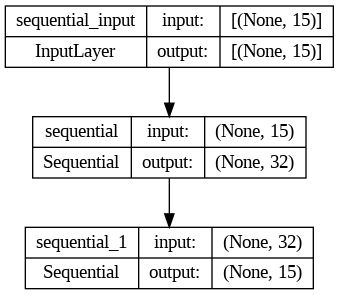

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

model_name = 'ae_aug_ninit10000_val001'

# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dense(hidden_dim, activation='relu')
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoding_dim, activation='relu', input_shape=(hidden_dim,)),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

ae_default = tf.keras.Sequential([encoder, decoder])
plot_model(model, to_file='model_shapes.png', show_shapes=True)

In [ ]:
# Compile and train the autoencoder with early stopping
ae_default.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = ae_default.fit(train_data_scaled, train_data_scaled, epochs=10000, batch_size=32, validation_split=0.01, callbacks=[early_stopping], verbose=1)
ae_default.save(f"{model_name}.h5")

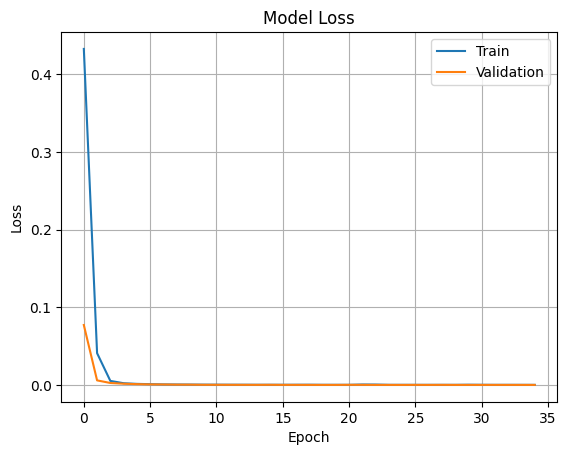

In [ ]:
 # 모델 학습 과정 시각화
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 학습된 모델 로드
model = tf.keras.models.load_model(f"{model_name}.h5")

# Calculate the reconstruction error for test_data
test_data_reconstructed = model.predict(test_data_scaled)
reconstruction_error = np.mean(np.square(test_data_scaled - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error, 95.34)
threshold2 = np.percentile(reconstruction_error, 95.35)
threshold3 = np.percentile(reconstruction_error, 95.38)

# Predict anomalies in test_data
prediction = (reconstruction_error > threshold).astype(int)
prediction2 = (reconstruction_error > threshold2).astype(int)
prediction3 = (reconstruction_error > threshold3).astype(int)

231/231 [==============================] - 0s 1ms/step


### PyTorch 규진

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch

# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load your train_data and test_data
# Assuming train_data and test_data are in the form of NumPy arrays or pandas DataFrames

# Preprocess the data
#pca = PCA(n_components=10)
#train_data_pca = pca.fit_transform(train_data)
#test_data_pca = pca.transform(test_data)

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Split the train data into train and validation sets
train_data, val_data = train_test_split(train_data_scaled, test_size=0.1, random_state=42)

# Convert the data to PyTorch tensors
train_data_torch = torch.tensor(train_data, dtype=torch.float32)
val_data_torch = torch.tensor(val_data, dtype=torch.float32)
test_data_torch = torch.tensor(test_data_scaled, dtype=torch.float32)

# Define the autoencoder architecture
input_dim = train_data_torch.shape[1]
encoding_dim = 64
hidden_dim1 = 32

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder()
print(autoencoder)

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# # Define early stopping criteria
# patience = 7
# min_delta = 0.01
# best_loss = float('inf')
# counter = 0

# # Train the autoencoder
# num_epochs = 1000
# batch_size = 32
# train_data_loader = torch.utils.data.DataLoader(train_data_torch, batch_size=batch_size, shuffle=True)
# for epoch in range(num_epochs):
#     train_loss = 0
#     for data in train_data_loader:
#         inputs = data
#         optimizer.zero_grad()
#         outputs = autoencoder(inputs)
#         loss = criterion(outputs, inputs)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Check early stopping criteria using the validation data
#     with torch.no_grad():
#         val_data_reconstructed = autoencoder(val_data_torch)
#         val_loss = criterion(val_data_reconstructed, val_data_torch)
#         if val_loss.item() < (best_loss - min_delta):
#             best_loss = val_loss.item()
#             counter = 0
#             torch.save(autoencoder.state_dict(), 'ae_pca_ft49_th934.pth')
#         else:
#             counter += 1
#             if counter >= patience:

#                 print("Early stopping criteria met.")
#                 break

#     # Print progress
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_data_loader)}, Val Loss: {val_loss.item()}")

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=15, bias=True)
    (3): Sigmoid()
  )
)


### PyTorch 모델링

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

In [ ]:
# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, hidden_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, input_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, encoding_dim, hidden_dim)
        self.decoder = Decoder(input_dim, encoding_dim, hidden_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [ ]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32

ae_default = AutoEncoder(input_dim, encoding_dim, hidden_dim)

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(ae_default.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(ae_default)

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=15, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=32, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=15, bias=True)
    (activation): ReLU()
  )
)


In [ ]:
model_name = 'pytorch_first'

for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = ae_default(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(ae_default(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(ae_default.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.4153425129167539, val loss: 0.22191183269023895
Epoch 2, train loss: 0.1715249038062055, val loss: 0.20372958481311798
Epoch 3, train loss: 0.1313958492552029, val loss: 0.10011718422174454
Epoch 4, train loss: 0.08633097796313316, val loss: 0.08960530906915665
Epoch 5, train loss: 0.06807027831885372, val loss: 0.0708831176161766
Epoch 6, train loss: 0.048667303298214705, val loss: 0.06674424558877945
Epoch 7, train loss: 0.03350693375852308, val loss: 0.06995310634374619
Epoch 8, train loss: 0.02066021916273886, val loss: 0.061450403183698654
Epoch 9, train loss: 0.03746520088387368, val loss: 0.0656329020857811
Epoch 10, train loss: 0.03519565686190269, val loss: 0.03413302078843117
Epoch 11, train loss: 0.03127466799661826, val loss: 0.02794688008725643
Epoch 12, train loss: 0.010651163219909478, val loss: 0.021563848480582237
Epoch 13, train loss: 0.006007141291102983, val loss: 0.01998726837337017
Epoch 14, train loss: 0.003629718572536572, val loss: 0.0188

In [ ]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = ae_default(test_data_torch)
reconstruction_error = torch.mean(torch.square(test_data_torch - test_data_reconstructed), axis=1)

# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 95.34)

# Predict anomalies in test_data
test_predictions = (reconstruction_error.detach().numpy() > threshold).astype(int)

# Feature Importance 확인

motor_temp: 1.61
type: 1.36
motor_current: 1.33
motor_rpm: 1.33
air_density: 1.32
Discharge_Volume: 1.30
motor_vibe: 1.29
out_pressure: 1.28
air_end_temp: 1.28
Compressor_Efficiency1: 1.28
Motor_Efficiency: 1.26
air_inflow: 1.26
hp: 1.21
Compressor_Efficiency2: 1.18
air_inflow_per_motor_current: 1.06


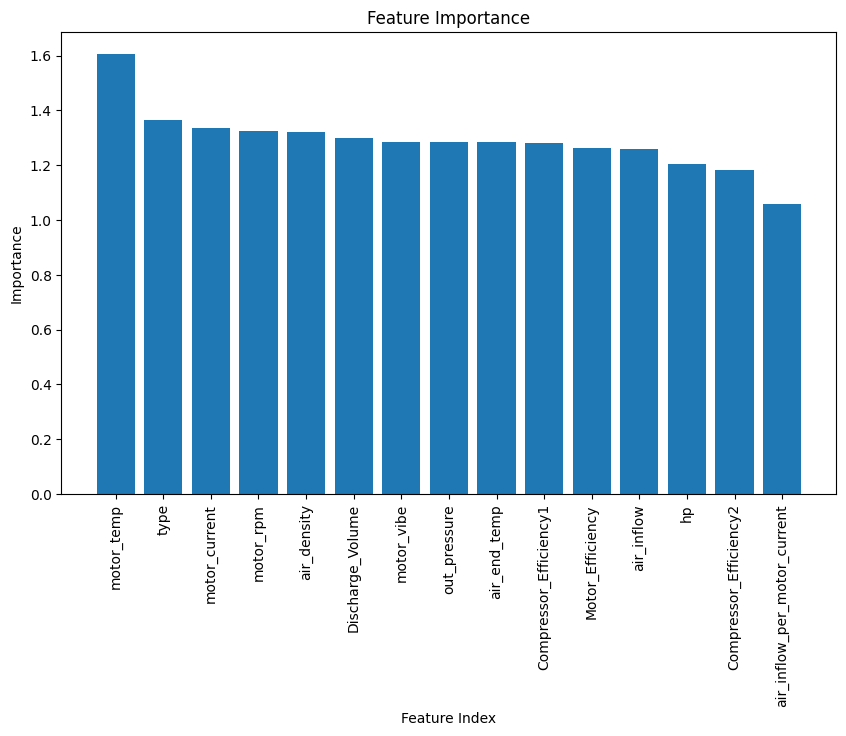

In [ ]:
import matplotlib.pyplot as plt

columns = final_data.columns

# Extract encoder layer and weights
encoder_layer = model.layers[0]
weights = encoder_layer.get_weights()[0]

# Calculate feature importance as the L2 norm of weights
feature_importance = np.linalg.norm(weights, axis=1)

# Sort feature importance in descending order
sorted_importance_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_importance_indices]

# Print sorted feature importance
for i in range(len(sorted_importance)):
    print('{}: {:.2f}'.format(columns[sorted_importance_indices[i]], sorted_importance[i]))

# Create bar chart of sorted feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_importance)), sorted_importance)
ax.set_title('Feature Importance')
ax.set_xlabel('Feature Index')
ax.set_ylabel('Importance')
ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(columns[sorted_importance_indices])
plt.xticks(rotation=90)
plt.show()

# 데이터 저장

In [ ]:
from collections import Counter

count = Counter(test_predictions)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  7044
Number of 1s:  345


In [ ]:
cnt = 0
for a, b in zip(test_predictions, prediction):
    if a != b:
        cnt +=1
print(cnt)

146


In [ ]:
file_name = model_name + '_th34_torch'

In [ ]:
# 코랩에 저장
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': test_predictions}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")